In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import shutil
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
import pandas as pd

In [2]:
def plot_categories(training_images, training_labels,mapping = None, count = 10):
  fig, axes = plt.subplots(int(np.sqrt(count))+1, int(np.sqrt(count))+1, figsize=(16, 15))
  axes = axes.flatten()
    
  for ax in axes:
    ax.set_axis_off()

  for k in range(count):
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.set_axis_on()
    ax.imshow(img, cmap="Greys_r")
    label = None
    if mapping:
        label = mapping[training_labels[k]]
    else:
        label = training_labels[k]
        
    ax.set_title(label)
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

In [4]:

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
    
    
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-tumor detected (True Negatives): ', cm[0][0])
  print('Non-tumor incorrectly detected (False Positives): ', cm[0][1])
  print('Tumor missed (False Negatives): ', cm[1][0])
  print('Tumor detected (True Positives): ', cm[1][1])
  print('Total case: ', np.sum(cm[1]))

In [5]:
data_path = pathlib.Path("cancerIA-dataset/")
data_path = os.path.join(data_path, os.listdir(data_path)[0])

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 532 images belonging to 2 classes.
Found 132 images belonging to 2 classes.


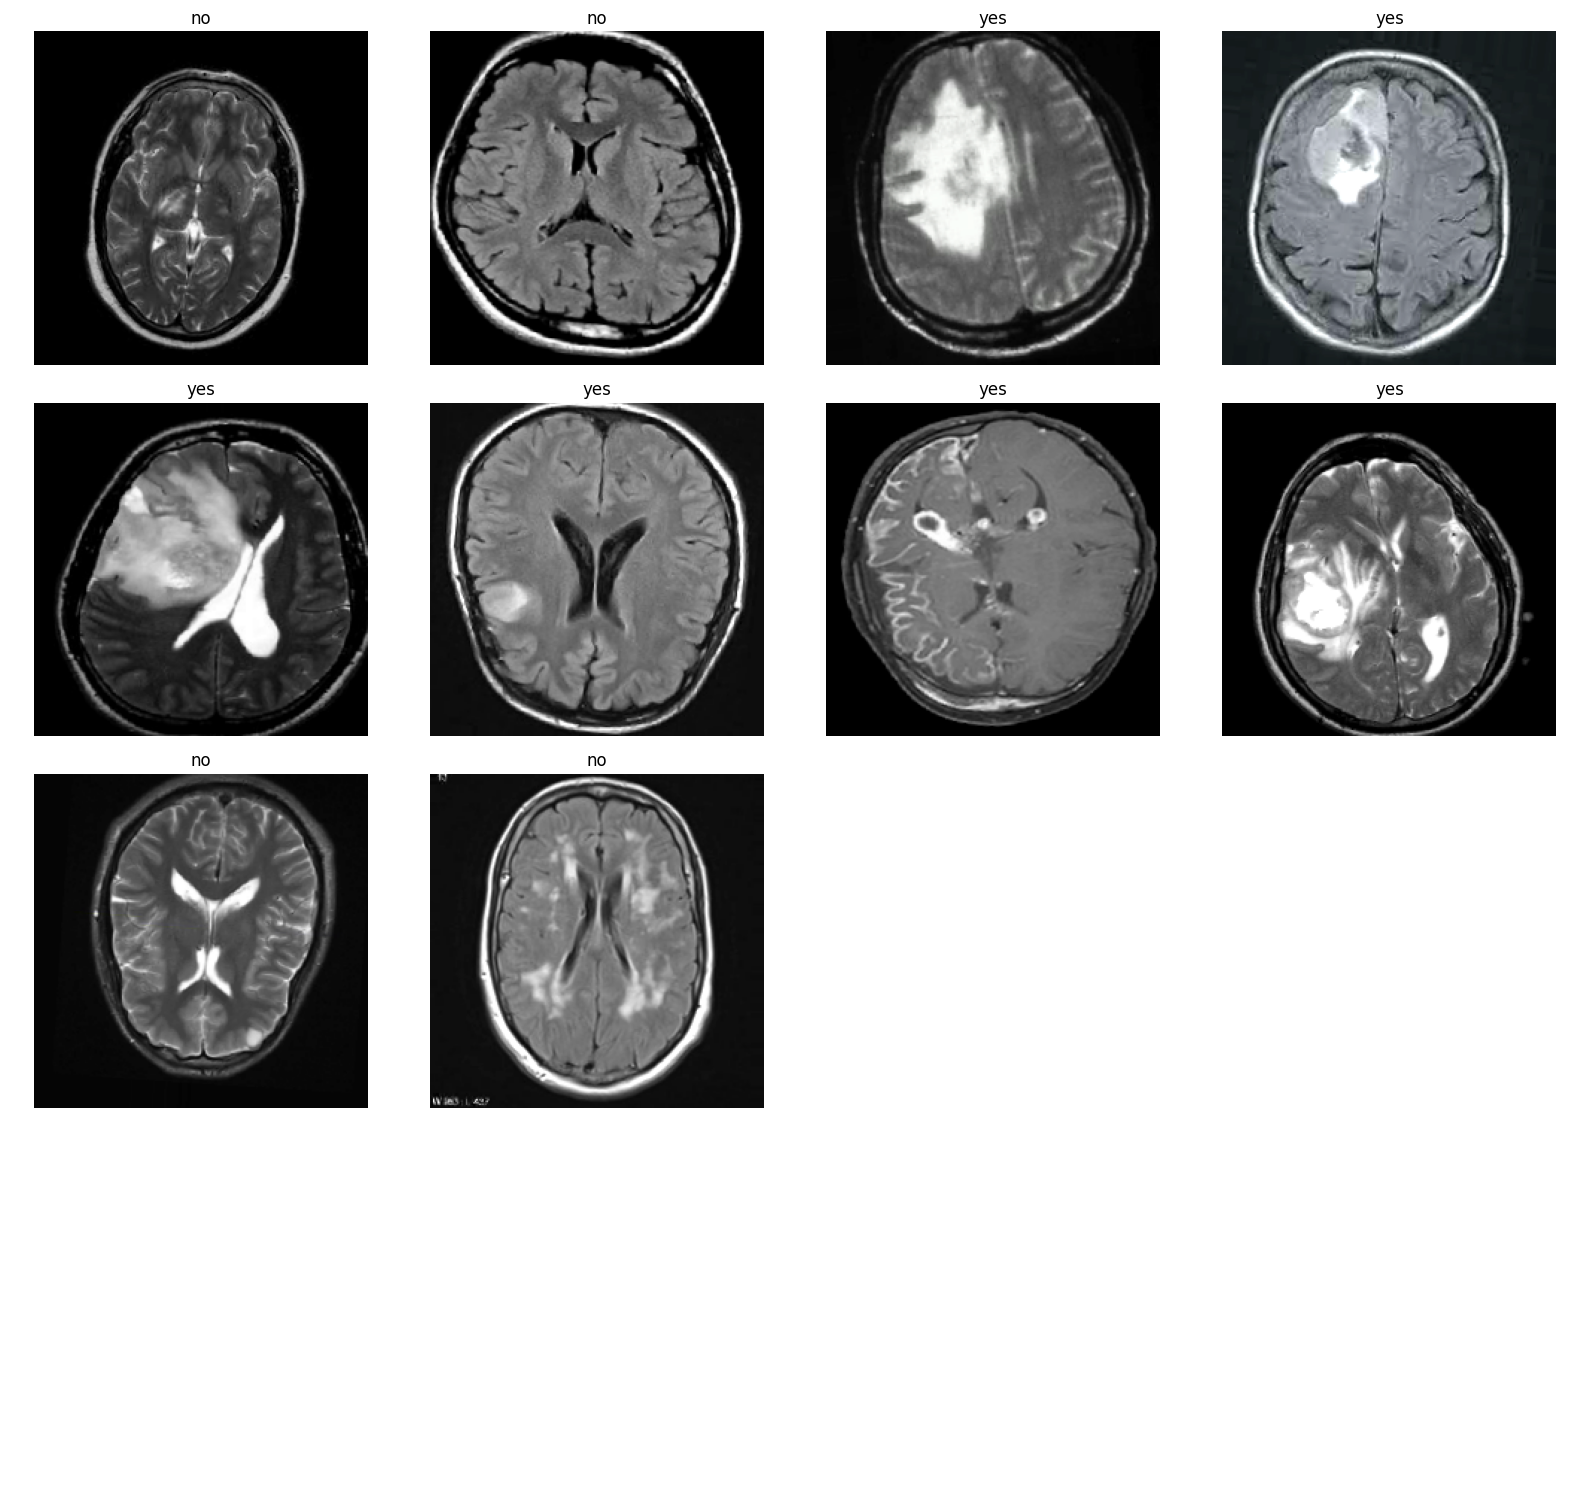

In [7]:
sample_X, sample_y = next(train_generator)
mapping = {1: "yes", 0: "no"}

plot_categories(sample_X, sample_y, mapping, sample_X.shape[0])


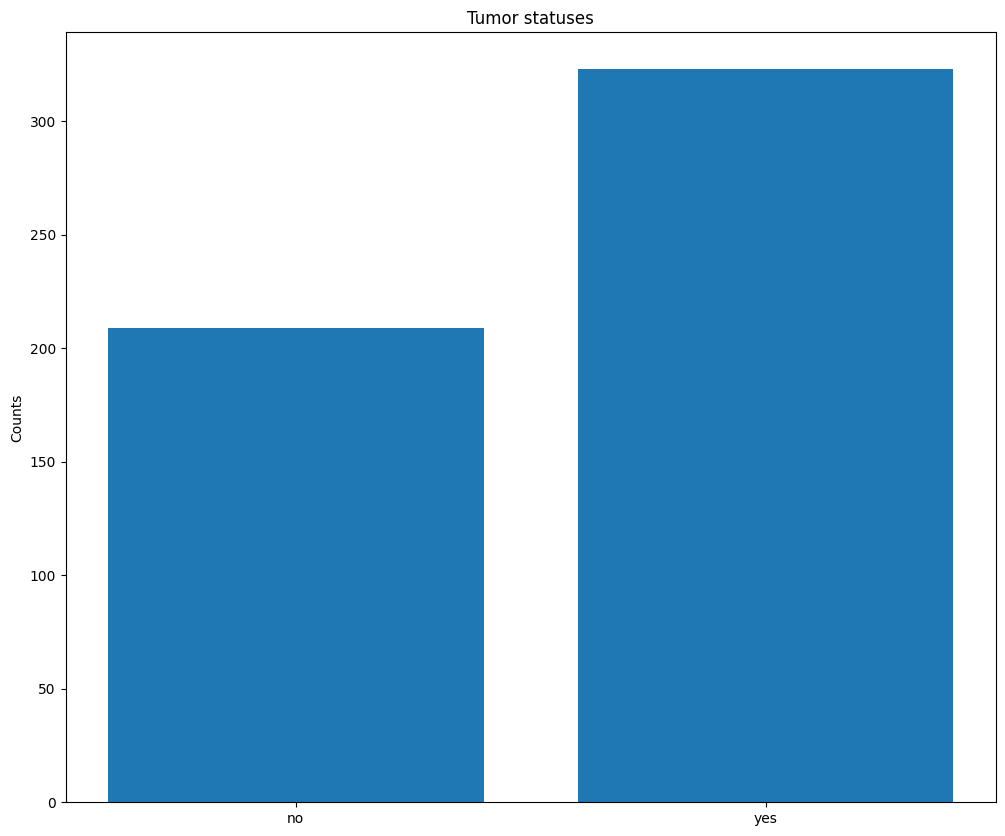

In [8]:
labels, counts = np.unique(train_generator.labels, return_counts = True)
labels = [mapping[l] for l in labels]

fig, ax = plt.subplots()
ax.set_ylabel('Counts')
ax.set_title('Tumor statuses')
ax.bar(labels, counts)

plt.show()

In [9]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
train_class_weights = dict(enumerate(class_weights))


In [10]:
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

# SIMPLE LENET CNN MODEL

In [11]:
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3), activation="relu", input_shape=(224,224,3)),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 512 , activation="relu"),
      tf.keras.layers.Dropout(rate = 0.5),
      tf.keras.layers.Dense(units = 1 , activation="sigmoid")
  ])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
                loss = "binary_crossentropy",
                metrics=metrics)

tf.keras.utils.plot_model(model) 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,345 (3.18 MB)

 Trainable params: 833,345 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# EPOCH SIZE 10
history1 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6527 - auc: 0.6842 - fn: 47.5636 - fp: 42.6000 - loss: 0.6365 - prc: 0.7517 - precision: 0.7198 - recall: 0.6871 - tn: 63.6545 - tp: 118.2909 - val_accuracy: 0.7424 - val_auc: 0.7841 - val_fn: 13.0000 - val_fp: 21.0000 - val_loss: 0.5538 - val_prc: 0.8324 - val_precision: 0.7614 - val_recall: 0.8375 - val_tn: 31.0000 - val_tp: 67.0000
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.7487 - auc: 0.7949 - fn: 31.0727 - fp: 33.1818 - loss: 0.5599 - prc: 0.8068 - precision: 0.7845 - recall: 0.8024 - tn: 72.6182 - tp: 136.1091 - val_accuracy: 0.7500 - val_auc: 0.8084 - val_fn: 17.0000 - val_fp: 16.0000 - val_loss: 0.5455 - val_prc: 0.8464 - val_precision: 0.7975 - val_recall: 0.7875 - val_tn: 36.0000 - val_tp: 63.0000
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.7821 - auc: 0.8105 - fn: 25.6727 - fp: 33.2909 - loss: 0.5258 - prc: 0.8330 - precision: 0.8178 - recall: 0.8281 - tn: 74.4545 - tp: 139.85

In [14]:
validation_results1 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results1):
  print(name, ': ', value)

loss :  0.46649032831192017
compile_metrics :  70.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Non-tumor detected (True Negatives):  37
Non-tumor incorrectly detected (False Positives):  15
Tumor missed (False Negatives):  11
Tumor detected (True Positives):  69
Total case:  80


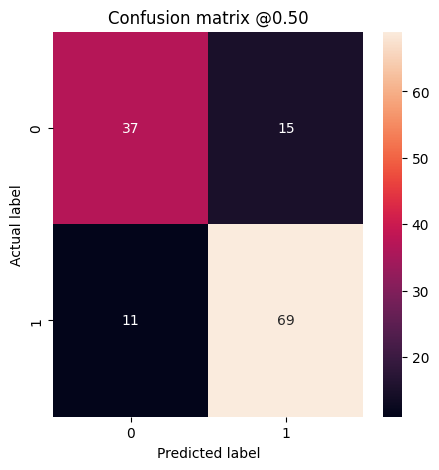

In [15]:
validation_predictions1 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions1)

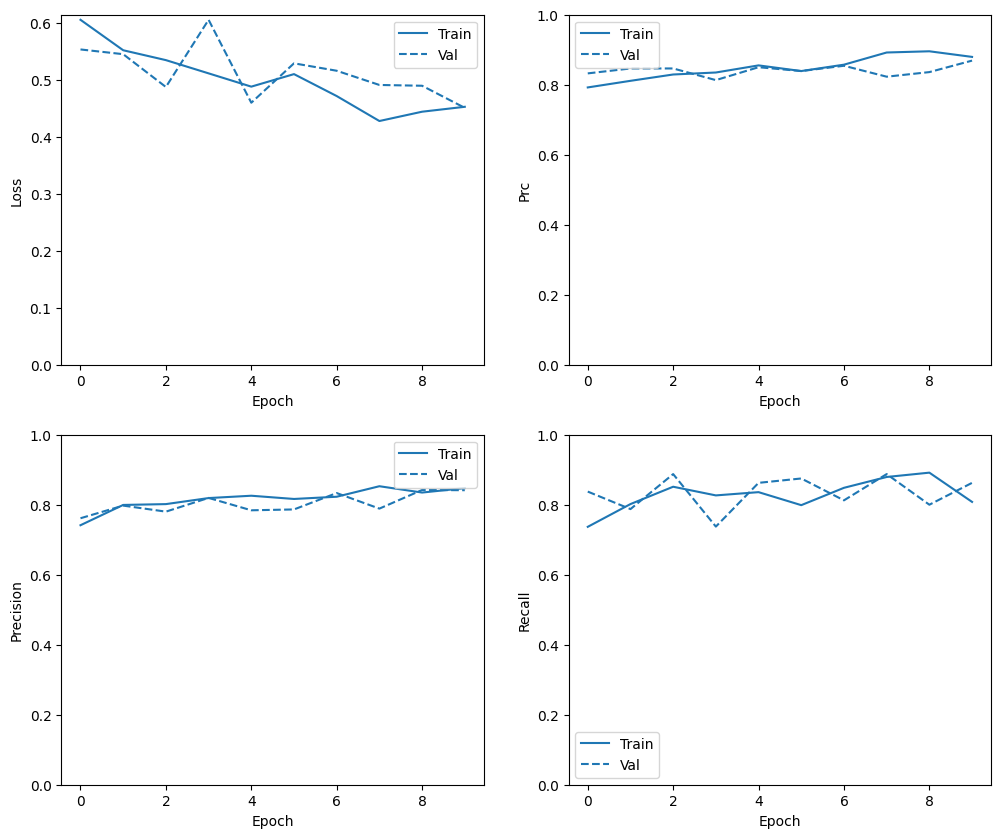

In [16]:
plot_metrics(history1)

In [17]:
# EPOCH SIZE 20
history2 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.8652 - auc: 0.9328 - fn: 19.6182 - fp: 20.8182 - loss: 0.3418 - prc: 0.9554 - precision: 0.8842 - recall: 0.8999 - tn: 84.7455 - tp: 149.4000 - val_accuracy: 0.8409 - val_auc: 0.8743 - val_fn: 9.0000 - val_fp: 12.0000 - val_loss: 0.3990 - val_prc: 0.8779 - val_precision: 0.8554 - val_recall: 0.8875 - val_tn: 40.0000 - val_tp: 71.0000
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.8376 - auc: 0.9178 - fn: 22.2727 - fp: 23.6364 - loss: 0.3724 - prc: 0.9297 - precision: 0.8674 - recall: 0.8711 - tn: 82.2182 - tp: 145.0000 - val_accuracy: 0.8258 - val_auc: 0.8613 - val_fn: 9.0000 - val_fp: 14.0000 - val_loss: 0.5151 - val_prc: 0.8553 - val_precision: 0.8353 - val_recall: 0.8875 - val_tn: 38.0000 - val_tp: 71.0000
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.8420 - auc: 0.8905 - fn: 21.4000 - fp: 20.0727 - loss: 0.4209 - prc: 0.9076 - precision: 0.8675 - recall: 0.8680 - tn: 90.1273 - t

In [18]:
validation_results2 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results2):
  print(name, ': ', value)

loss :  0.5500714182853699
compile_metrics :  73.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Non-tumor detected (True Negatives):  40
Non-tumor incorrectly detected (False Positives):  12
Tumor missed (False Negatives):  8
Tumor detected (True Positives):  72
Total case:  80


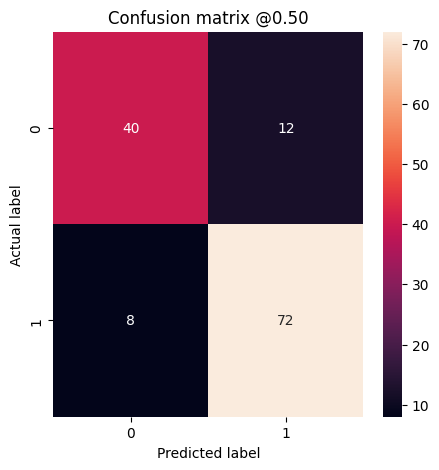

In [19]:
validation_predictions2 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions2)

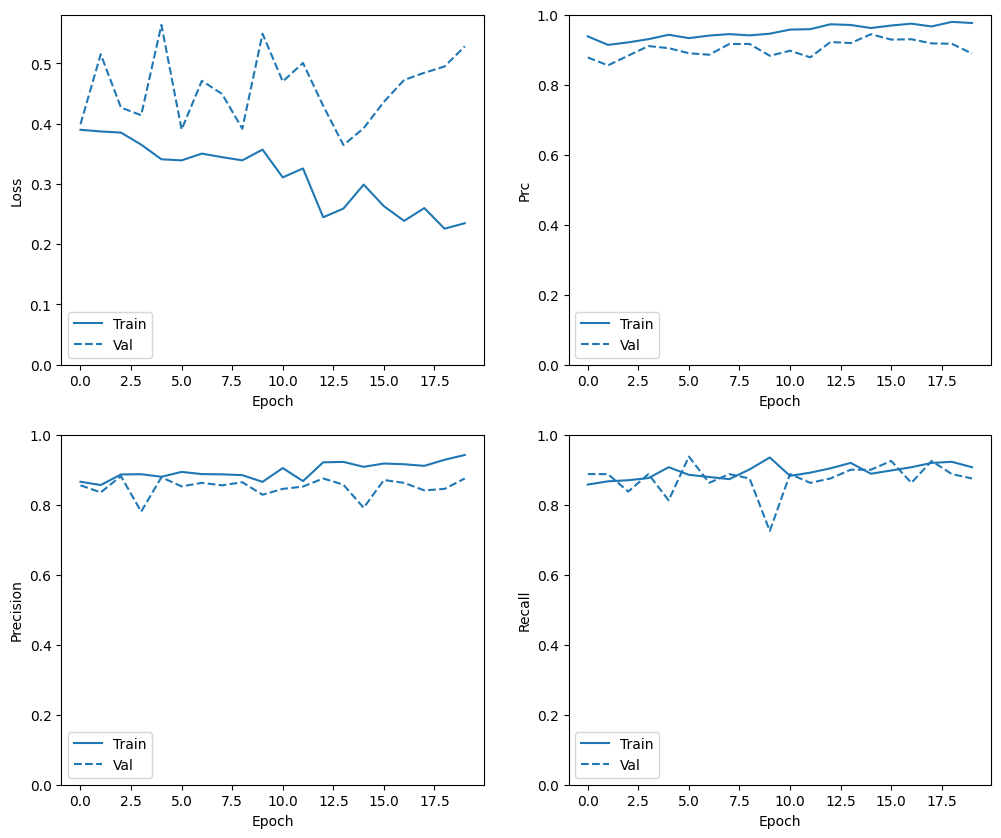

In [20]:
plot_metrics(history2)

In [21]:
# EPOCH SIZE 40
history3 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9253 - auc: 0.9801 - fn: 10.5455 - fp: 10.1455 - loss: 0.1831 - prc: 0.9870 - precision: 0.9377 - recall: 0.9412 - tn: 95.8182 - tp: 155.3091 - val_accuracy: 0.8485 - val_auc: 0.8845 - val_fn: 9.0000 - val_fp: 11.0000 - val_loss: 0.5547 - val_prc: 0.8962 - val_precision: 0.8659 - val_recall: 0.8875 - val_tn: 41.0000 - val_tp: 71.0000
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9064 - auc: 0.9712 - fn: 15.4727 - fp: 9.5636 - loss: 0.2162 - prc: 0.9793 - precision: 0.9456 - recall: 0.8944 - tn: 101.7636 - tp: 150.1091 - val_accuracy: 0.8030 - val_auc: 0.9061 - val_fn: 14.0000 - val_fp: 12.0000 - val_loss: 0.5170 - val_prc: 0.9411 - val_precision: 0.8462 - val_recall: 0.8250 - val_tn: 40.0000 - val_tp: 66.0000
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9350 - auc: 0.9807 - fn: 12.4909 - fp: 8.6909 - loss: 0.1761 - prc: 0.9874 - precision: 0.9572 - recall: 0.9375 - tn: 96.0182 - t

In [22]:
validation_results3 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results3):
  print(name, ': ', value)

loss :  0.5629916787147522
compile_metrics :  71.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Non-tumor detected (True Negatives):  45
Non-tumor incorrectly detected (False Positives):  7
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  73
Total case:  80


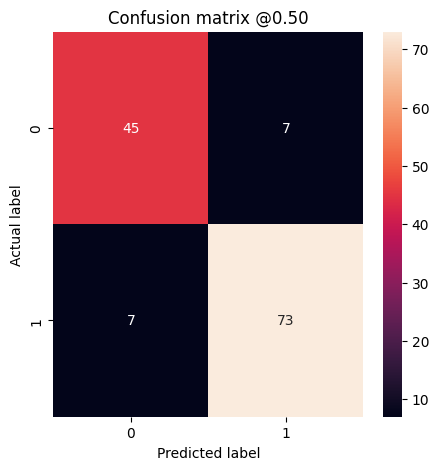

In [23]:
validation_predictions3 = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions3)

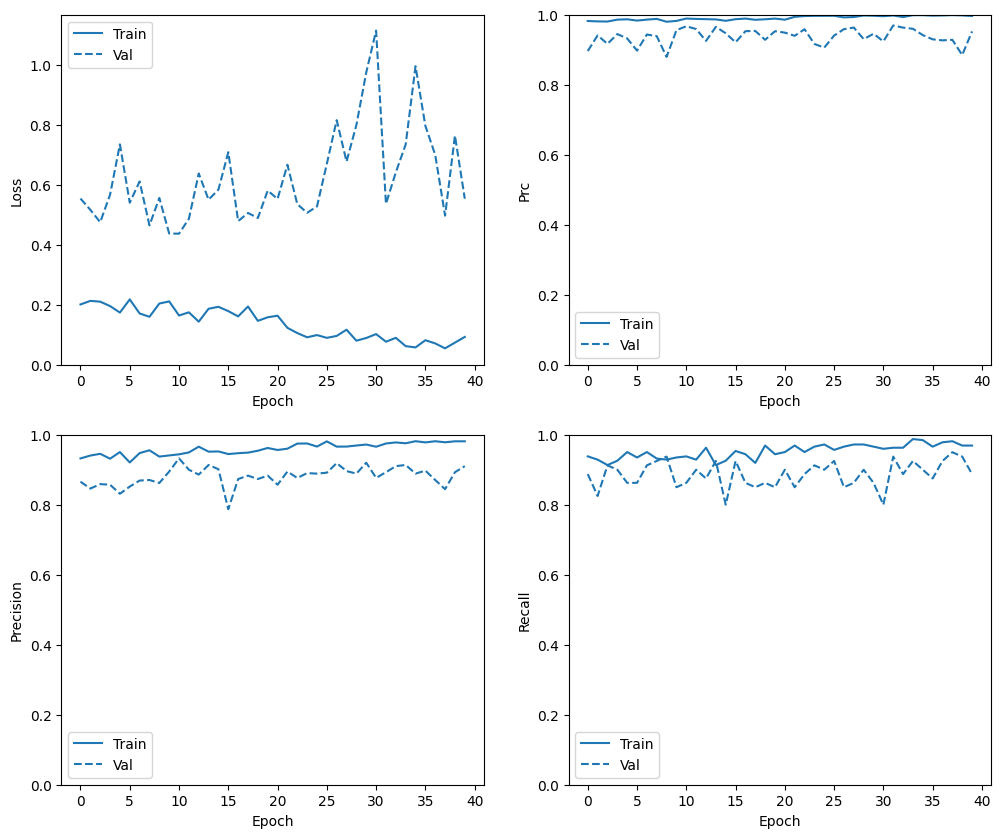

In [24]:
plot_metrics(history3)

# RESNETV2 MODEL

In [25]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,252,193 (226.03 MB)

 Trainable params: 4,915,457 (18.75 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [26]:
# EPOCH SIZE 10
history4 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7258 - auc: 0.7847 - fn: 64.6364 - fp: 46.9091 - loss: 1.8308 - prc: 0.8052 - precision: 0.7957 - recall: 0.7397 - tn: 110.6909 - tp: 182.3091 - val_accuracy: 0.8106 - val_auc: 0.9231 - val_fn: 20.0000 - val_fp: 5.0000 - val_loss: 0.4350 - val_prc: 0.9506 - val_precision: 0.9231 - val_recall: 0.7500 - val_tn: 47.0000 - val_tp: 60.0000
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8415 - auc: 0.9276 - fn: 27.1455 - fp: 17.5273 - loss: 0.3510 - prc: 0.9464 - precision: 0.9018 - recall: 0.8343 - tn: 89.8000 - tp: 137.6364 - val_accuracy: 0.8788 - val_auc: 0.9415 - val_fn: 9.0000 - val_fp: 7.0000 - val_loss: 0.3136 - val_prc: 0.9590 - val_precision: 0.9103 - val_recall: 0.8875 - val_tn: 45.0000 - val_tp: 71.0000
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8977 - auc: 0.9502 - fn: 17.9091 - fp: 10.6727 - loss: 0.2824 - prc: 0.9613 - precision: 0.9431 - recall: 0.8933 - tn: 93.3455 - tp: 15

In [27]:
validation_results4 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results4):
  print(name, ': ', value)

loss :  0.26576727628707886
compile_metrics :  72.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
Non-tumor detected (True Negatives):  44
Non-tumor incorrectly detected (False Positives):  8
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  78
Total case:  80


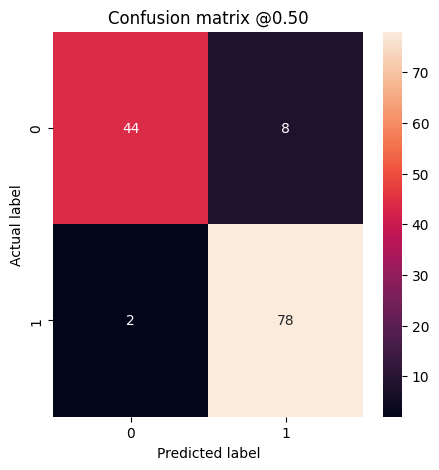

In [28]:
validation_predictions4 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions4)

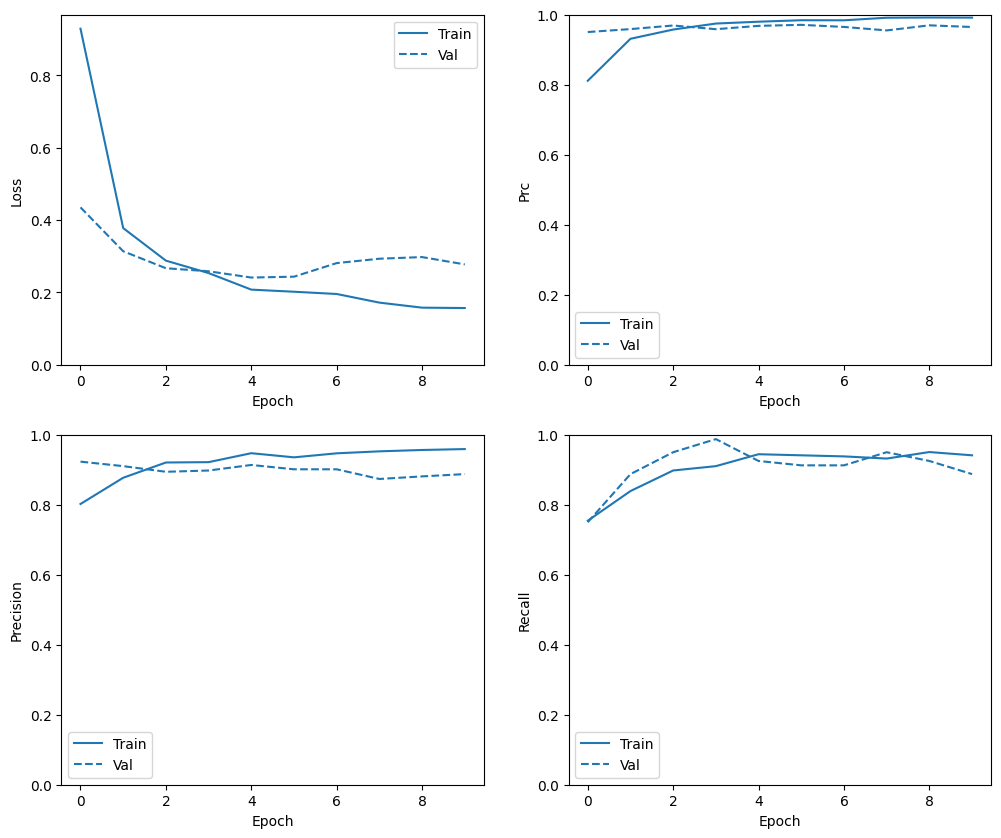

In [29]:
plot_metrics(history4)

In [30]:
# EPOCH SIZE 20
history5 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9547 - auc: 0.9945 - fn: 8.7636 - fp: 5.0000 - loss: 0.1176 - prc: 0.9968 - precision: 0.9767 - recall: 0.9500 - tn: 100.3636 - tp: 161.6182 - val_accuracy: 0.8788 - val_auc: 0.9615 - val_fn: 13.0000 - val_fp: 3.0000 - val_loss: 0.3267 - val_prc: 0.9763 - val_precision: 0.9571 - val_recall: 0.8375 - val_tn: 49.0000 - val_tp: 67.0000
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9791 - auc: 0.9899 - fn: 2.9455 - fp: 4.1818 - loss: 0.1134 - prc: 0.9908 - precision: 0.9772 - recall: 0.9877 - tn: 107.0727 - tp: 159.8000 - val_accuracy: 0.9242 - val_auc: 0.9556 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.2510 - val_prc: 0.9681 - val_precision: 0.9070 - val_recall: 0.9750 - val_tn: 44.0000 - val_tp: 78.0000
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9675 - auc: 0.9937 - fn: 5.4909 - fp: 4.6364 - loss: 0.1019 - prc: 0.9944 - precision: 0.9750 - recall: 0.9706 - tn: 106.9091 - tp: 162.490

In [31]:
validation_results5 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results5):
  print(name, ': ', value)

loss :  0.27700936794281006
compile_metrics :  77.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 915ms/step
Non-tumor detected (True Negatives):  45
Non-tumor incorrectly detected (False Positives):  7
Tumor missed (False Negatives):  1
Tumor detected (True Positives):  79
Total case:  80


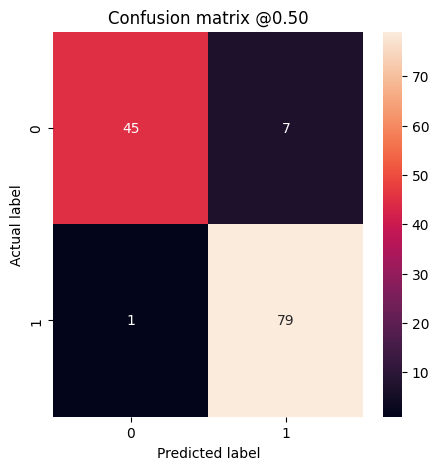

In [32]:
validation_predictions5 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions5)

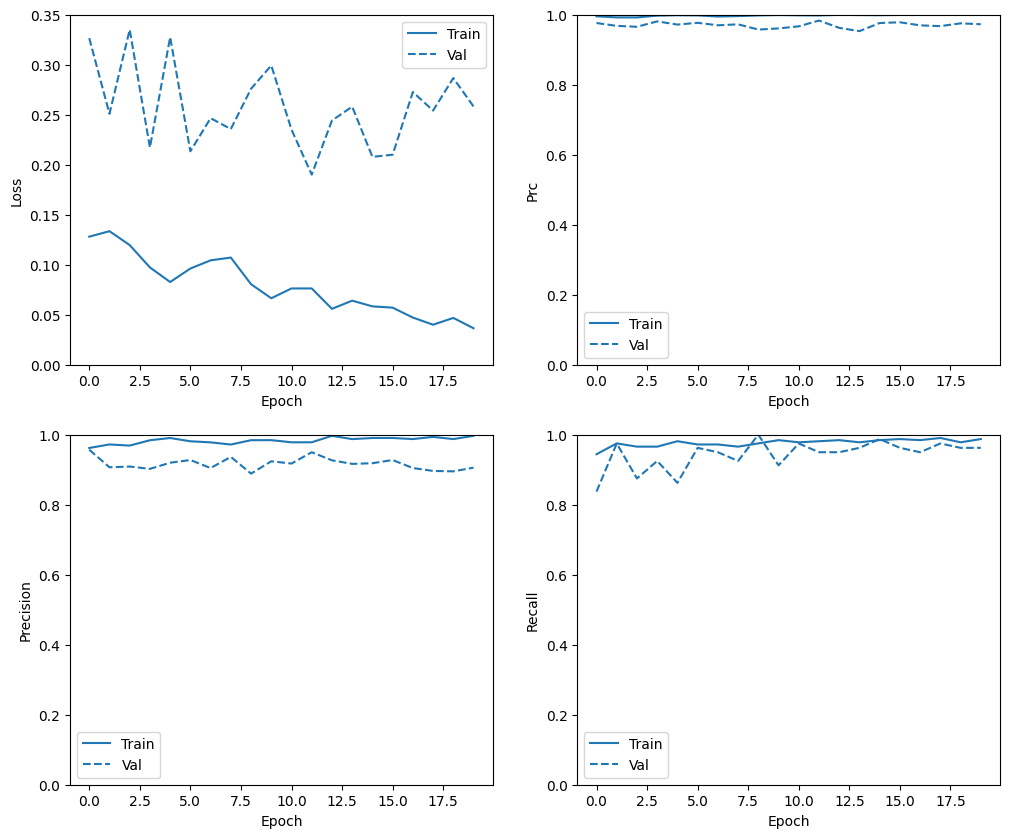

In [33]:
plot_metrics(history5)

In [34]:
# EPOCH SIZE 40
history6 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9993 - auc: 0.9999 - fn: 0.3091 - fp: 0.0000e+00 - loss: 0.0306 - prc: 0.9999 - precision: 1.0000 - recall: 0.9989 - tn: 112.6545 - tp: 163.0727 - val_accuracy: 0.8939 - val_auc: 0.9643 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.2769 - val_prc: 0.9745 - val_precision: 0.9231 - val_recall: 0.9000 - val_tn: 46.0000 - val_tp: 72.0000
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9844 - auc: 0.9992 - fn: 1.0000 - fp: 2.0000 - loss: 0.0397 - prc: 0.9993 - precision: 0.9870 - recall: 0.9833 - tn: 112.5818 - tp: 163.8000 - val_accuracy: 0.8788 - val_auc: 0.9612 - val_fn: 8.0000 - val_fp: 8.0000 - val_loss: 0.3358 - val_prc: 0.9730 - val_precision: 0.9000 - val_recall: 0.9000 - val_tn: 44.0000 - val_tp: 72.0000
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9902 - auc: 0.9996 - fn: 2.6545 - fp: 0.9273 - loss: 0.0419 - prc: 0.9997 - precision: 0.9959 - recall: 0.9880 - tn: 107.6909 - tp: 163.

In [35]:
validation_results6 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results6):
  print(name, ': ', value)

loss :  0.37966662645339966
compile_metrics :  79.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 873ms/step
Non-tumor detected (True Negatives):  42
Non-tumor incorrectly detected (False Positives):  10
Tumor missed (False Negatives):  1
Tumor detected (True Positives):  79
Total case:  80


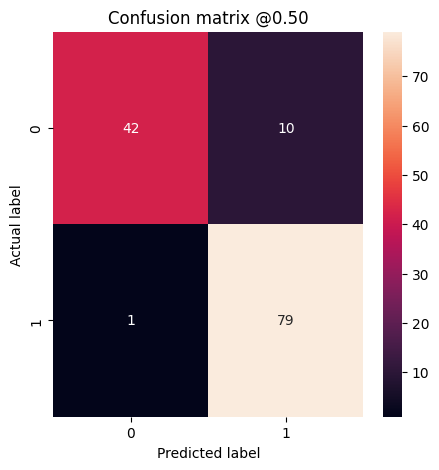

In [36]:
validation_predictions6 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions6)

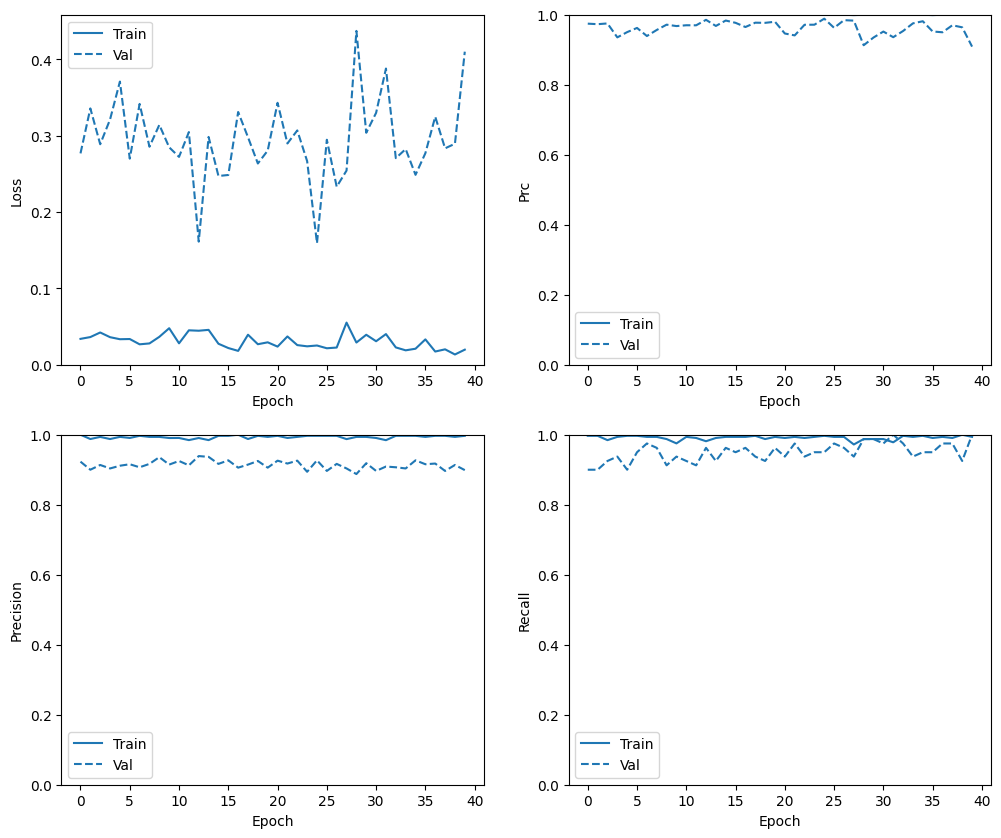

In [37]:
plot_metrics(history6)

# VGG16 MODEL

In [38]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalMaxPooling2D(),
                              tf.keras.layers.Dense(4096, activation = 'relu'),
                              tf.keras.layers.Dropout(rate=0.5),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

In [39]:
# EPOCH SIZE 10
history7 = model.fit(
    train_generator,epochs = 10, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.7189 - auc: 0.7955 - fn: 61.9273 - fp: 57.0727 - loss: 0.6963 - prc: 0.8482 - precision: 0.7727 - recall: 0.7682 - tn: 100.0545 - tp: 187.9636 - val_accuracy: 0.8106 - val_auc: 0.8862 - val_fn: 8.0000 - val_fp: 17.0000 - val_loss: 0.4508 - val_prc: 0.8954 - val_precision: 0.8090 - val_recall: 0.9000 - val_tn: 35.0000 - val_tp: 72.0000
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7679 - auc: 0.8653 - fn: 38.0000 - fp: 26.2909 - loss: 0.4863 - prc: 0.8995 - precision: 0.8184 - recall: 0.7705 - tn: 85.4000 - tp: 124.8909 - val_accuracy: 0.8030 - val_auc: 0.8944 - val_fn: 15.0000 - val_fp: 11.0000 - val_loss: 0.4078 - val_prc: 0.8961 - val_precision: 0.8553 - val_recall: 0.8125 - val_tn: 41.0000 - val_tp: 65.0000
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7780 - auc: 0.8391 - fn: 41.5273 - fp: 23.5091 - loss: 0.5068 - prc: 0.8645 - precision: 0.8466 - recall: 0.7635 - tn: 86.2364 - tp:

In [40]:
validation_results7 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results7):
  print(name, ': ', value)

loss :  0.3170527517795563
compile_metrics :  73.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 913ms/step
Non-tumor detected (True Negatives):  40
Non-tumor incorrectly detected (False Positives):  12
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  73
Total case:  80


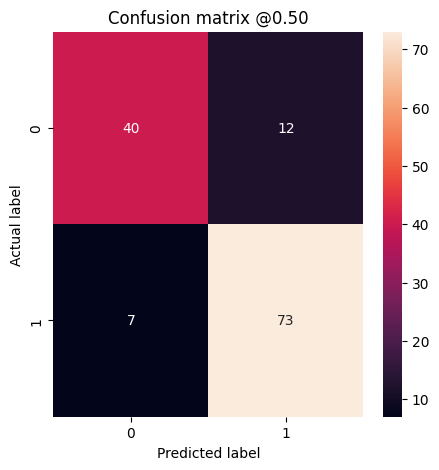

In [41]:
validation_predictions7 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions7)

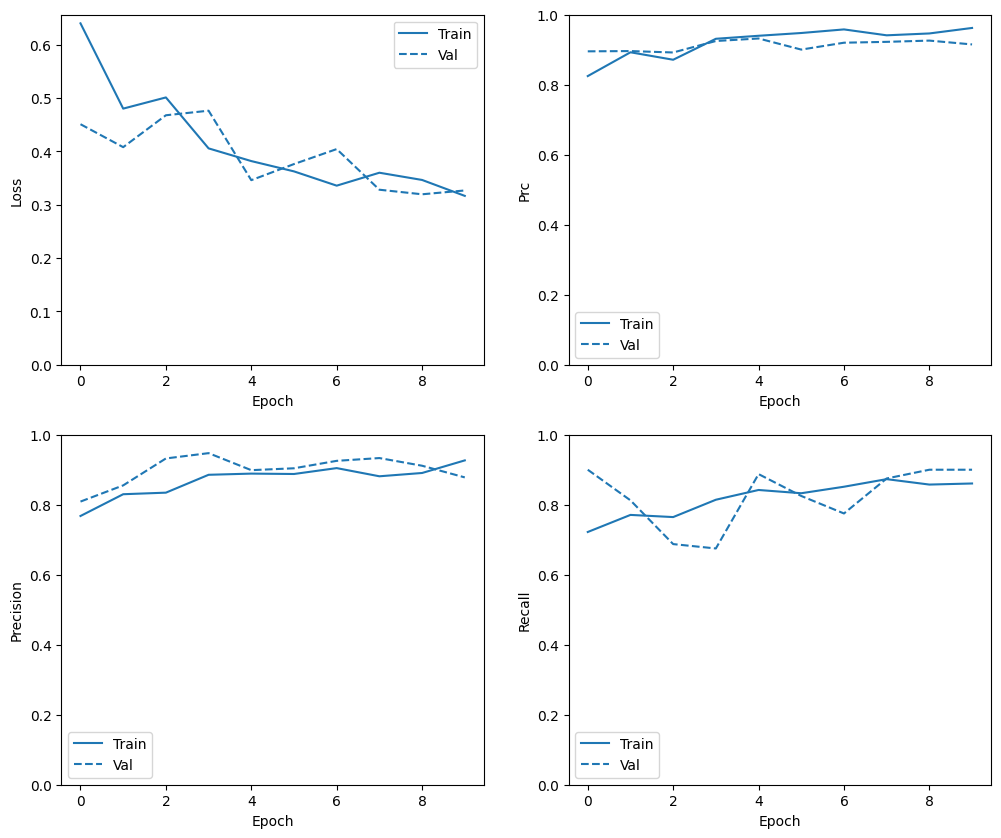

In [42]:
plot_metrics(history7)

In [43]:
# EPOCH SIZE 20
history8 = model.fit(
    train_generator,epochs = 20, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8289 - auc: 0.9244 - fn: 27.4182 - fp: 17.2364 - loss: 0.3559 - prc: 0.9435 - precision: 0.8683 - recall: 0.8276 - tn: 90.7455 - tp: 138.0182 - val_accuracy: 0.8409 - val_auc: 0.9314 - val_fn: 17.0000 - val_fp: 4.0000 - val_loss: 0.3687 - val_prc: 0.9269 - val_precision: 0.9403 - val_recall: 0.7875 - val_tn: 48.0000 - val_tp: 63.0000
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8952 - auc: 0.9590 - fn: 17.9818 - fp: 11.9636 - loss: 0.2845 - prc: 0.9715 - precision: 0.9282 - recall: 0.8922 - tn: 93.6727 - tp: 148.6364 - val_accuracy: 0.8409 - val_auc: 0.9282 - val_fn: 17.0000 - val_fp: 4.0000 - val_loss: 0.3952 - val_prc: 0.9099 - val_precision: 0.9403 - val_recall: 0.7875 - val_tn: 48.0000 - val_tp: 63.0000
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8655 - auc: 0.9440 - fn: 22.0000 - fp: 14.6182 - loss: 0.3064 - prc: 0.9599 - precision: 0.9011 - recall: 0.8738 - tn: 92.1091 - tp: 148

In [44]:
validation_results8 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results8):
  print(name, ': ', value)

loss :  0.3484506607055664
compile_metrics :  68.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Non-tumor detected (True Negatives):  46
Non-tumor incorrectly detected (False Positives):  6
Tumor missed (False Negatives):  16
Tumor detected (True Positives):  64
Total case:  80


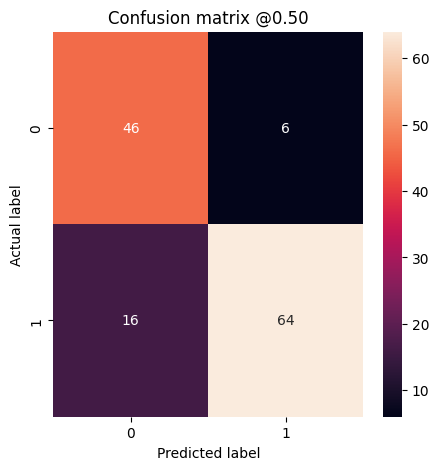

In [45]:
validation_predictions8 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions8)

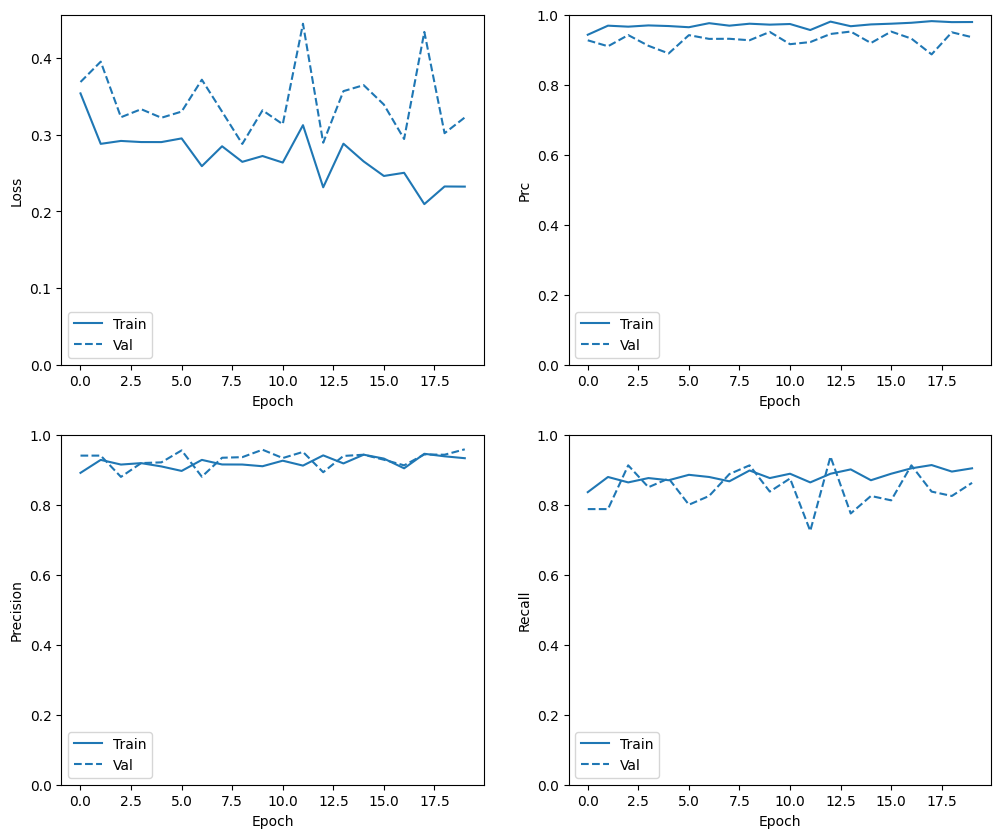

In [46]:
plot_metrics(history8)

In [47]:
# EPOCH SIZE 40
history9 = model.fit(
    train_generator,epochs = 40, 
    validation_data = validation_generator, 
    class_weight=train_class_weights)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8906 - auc: 0.9706 - fn: 22.3091 - fp: 7.8000 - loss: 0.2306 - prc: 0.9785 - precision: 0.9493 - recall: 0.8538 - tn: 103.7455 - tp: 138.5455 - val_accuracy: 0.8409 - val_auc: 0.9313 - val_fn: 15.0000 - val_fp: 6.0000 - val_loss: 0.3504 - val_prc: 0.9184 - val_precision: 0.9155 - val_recall: 0.8125 - val_tn: 46.0000 - val_tp: 65.0000
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8821 - auc: 0.9596 - fn: 16.2727 - fp: 11.3455 - loss: 0.2680 - prc: 0.9684 - precision: 0.9035 - recall: 0.8912 - tn: 99.4545 - tp: 146.0546 - val_accuracy: 0.8939 - val_auc: 0.9391 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.2931 - val_prc: 0.9215 - val_precision: 0.9125 - val_recall: 0.9125 - val_tn: 45.0000 - val_tp: 73.0000
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9124 - auc: 0.9796 - fn: 14.8909 - fp: 10.4545 - loss: 0.1996 - prc: 0.9859 - precision: 0.9305 - recall: 0.9191 - tn: 100.9636 - tp: 

In [48]:
validation_results9 = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results9):
  print(name, ': ', value)

loss :  0.4629628658294678
compile_metrics :  62.0


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 880ms/step
Non-tumor detected (True Negatives):  47
Non-tumor incorrectly detected (False Positives):  5
Tumor missed (False Negatives):  11
Tumor detected (True Positives):  69
Total case:  80


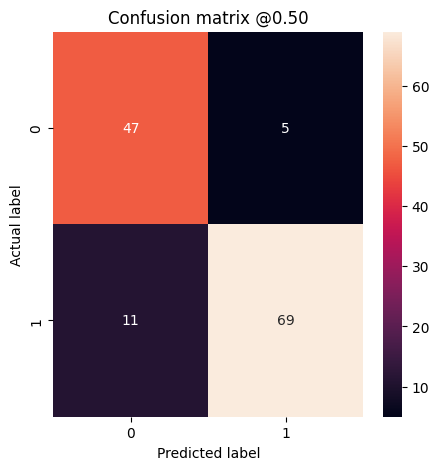

In [49]:
validation_predictions9 = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions9)

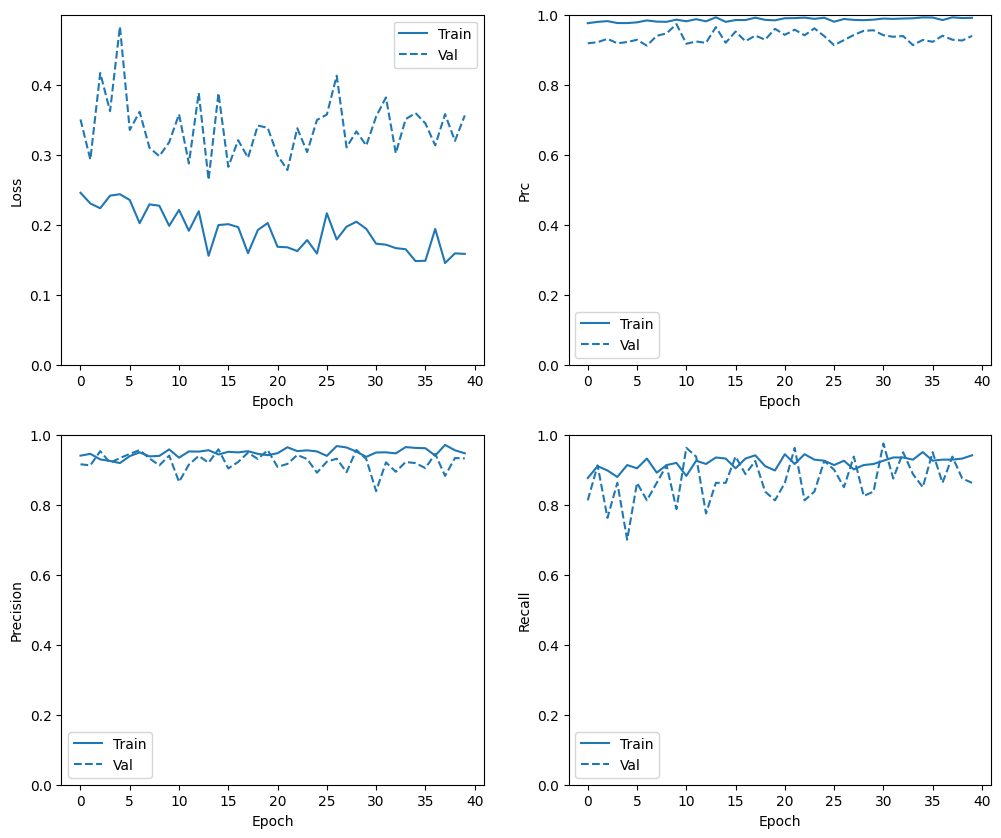

In [50]:
plot_metrics(history9)

# OVERALL RESULTS

In [51]:
res = [["Simple CNN [10 Epoch]", ],
       ["Simple CNN [20 Epoch]", ],
       ["Simple CNN [40 Epoch]", ],
       ["ResNetV2 [10 Epoch]", ],
       ["ResNetV2 [20 Epoch]", ],
       ["ResNetV2 [40 Epoch]", ],
       ["VGG16 [10 Epoch]", ],
       ["VGG16 [20 Epoch]", ], 
       ["VGG16 [40 Epoch]", ]]
histories = [history1,history2,history3,history4,history5,history6,history7,history8,history9]

for i,hist in enumerate(histories):
    
    hist_li = list(hist.history.values())
    
    acc = hist_li[15][0]
    precision = hist_li[16][0]
    recall = hist_li[17][0]
    max_auc = hist_li[18][0]
    
    mean_acc = np.mean(hist_li[15])
    mean_precision = np.mean(hist_li[16])
    mean_recall = np.mean(hist_li[17])
    mean_auc = np.mean(hist_li[18])
    
    
    for j in range(len(hist_li[16])):
        if hist_li[18][j] > max_auc: 
            
            acc = hist_li[15][j]
            precision = hist_li[16][j]
            recall = hist_li[17][j]
            max_auc = hist_li[18][j]
        
    
    res[i] += [precision,recall, max_auc, acc,mean_precision, mean_recall,mean_auc,mean_acc]
    
df = pd.DataFrame(res, columns = ["Model Name", f"Precision (with Max AUC)","Recall (with Max AUC)"," Max AUC", "Accuracy",
                                 "Mean Precision", "Mean Recall","Mean AUC", "Mean Accuracy"])

df

,Model Name,Precision (with Max AUC),Recall (with Max AUC),Max AUC,Accuracy,Mean Precision,Mean Recall,Mean AUC,Mean Accuracy
0,Simple CNN [10 Epoch],0.842105,0.8000,40.0,0.836067,0.803489,0.835000,35.500,0.840955
1,Simple CNN [20 Epoch],0.881579,0.8375,43.0,0.883103,0.850427,0.875000,39.600,0.903291
2,Simple CNN [40 Epoch],0.932432,0.8625,47.0,0.967049,0.881558,0.886563,42.375,0.937663
3,ResNetV2 [10 Epoch],0.923077,0.7500,47.0,0.950553,0.898324,0.908750,43.700,0.963153
4,ResNetV2 [20 Epoch],0.957143,0.8375,49.0,0.976305,0.916889,0.943125,45.100,0.970306
5,ResNetV2 [40 Epoch],0.935897,0.9125,47.0,0.971566,0.913713,0.949688,44.800,0.962407
6,VGG16 [10 Epoch],0.947368,0.6750,49.0,0.924898,0.899482,0.823750,44.300,0.912475
7,VGG16 [20 Epoch],0.955224,0.8000,49.0,0.941679,0.930387,0.843125,46.850,0.928527
8,VGG16 [40 Epoch],0.953125,0.7625,49.0,0.931139,0.922384,0.871563,45.975,0.935240


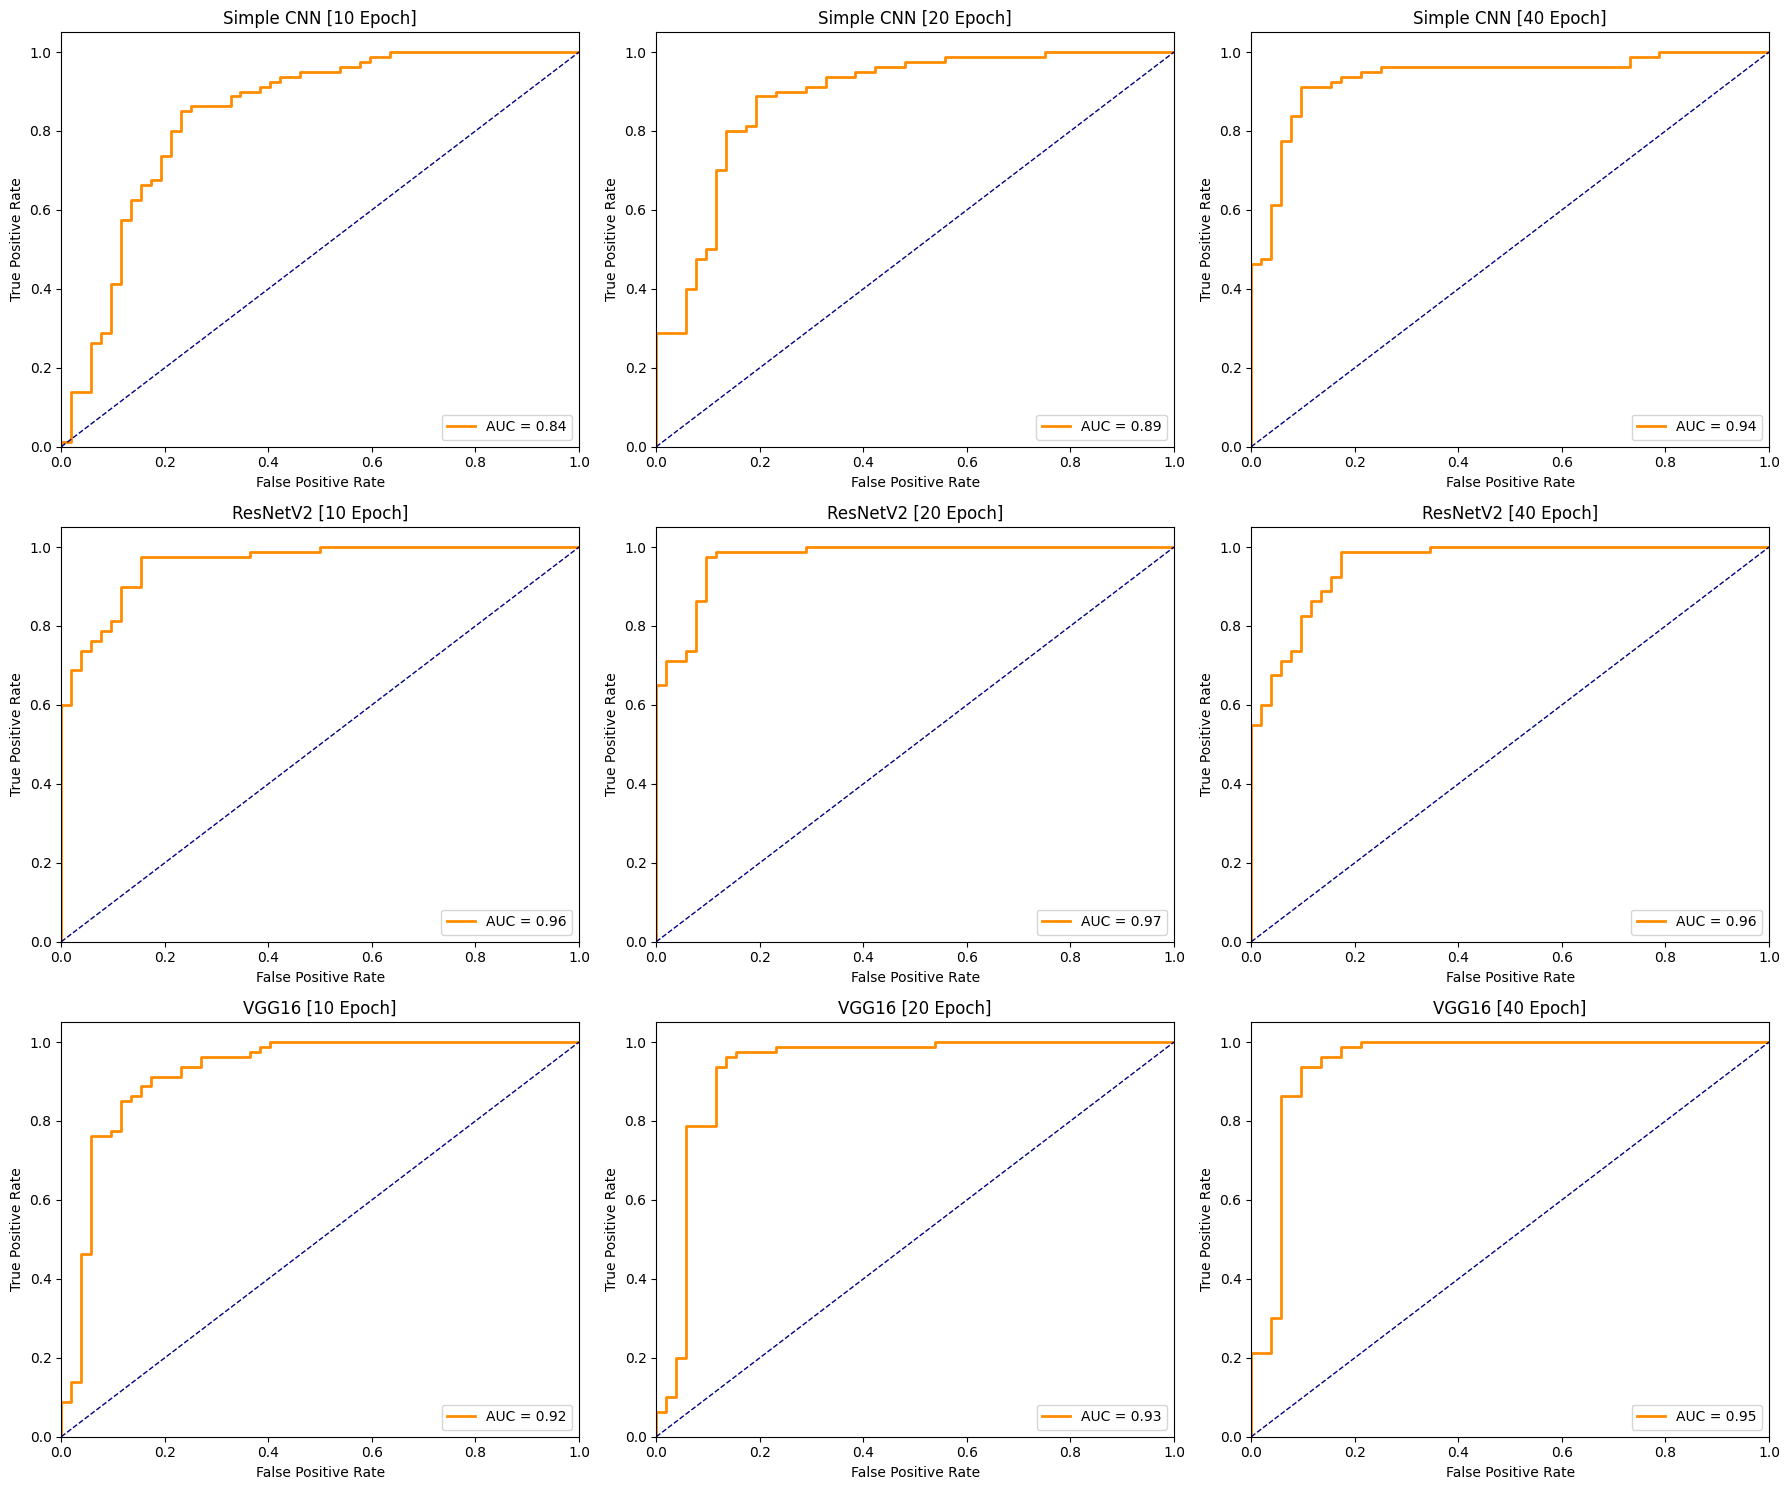

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

predictions = [
    validation_predictions1,
    validation_predictions2,
    validation_predictions3,
    validation_predictions4,
    validation_predictions5,
    validation_predictions6,
    validation_predictions7,
    validation_predictions8,
    validation_predictions9,
]

model_names = [
    "Simple CNN [10 Epoch]",
    "Simple CNN [20 Epoch]",
    "Simple CNN [40 Epoch]",
    "ResNetV2 [10 Epoch]",
    "ResNetV2 [20 Epoch]",
    "ResNetV2 [40 Epoch]",
    "VGG16 [10 Epoch]",
    "VGG16 [20 Epoch]",
    "VGG16 [40 Epoch]",
]


true_labels = validation_generator.labels  

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, (pred, name) in enumerate(zip(predictions, model_names)):
    ax = axes[i]

    if pred.shape[1] == 2:
        fpr, tpr, _ = roc_curve(true_labels, pred[:, 1])
    else:  
        fpr, tpr, _ = roc_curve(true_labels, pred)

    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_title(name)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


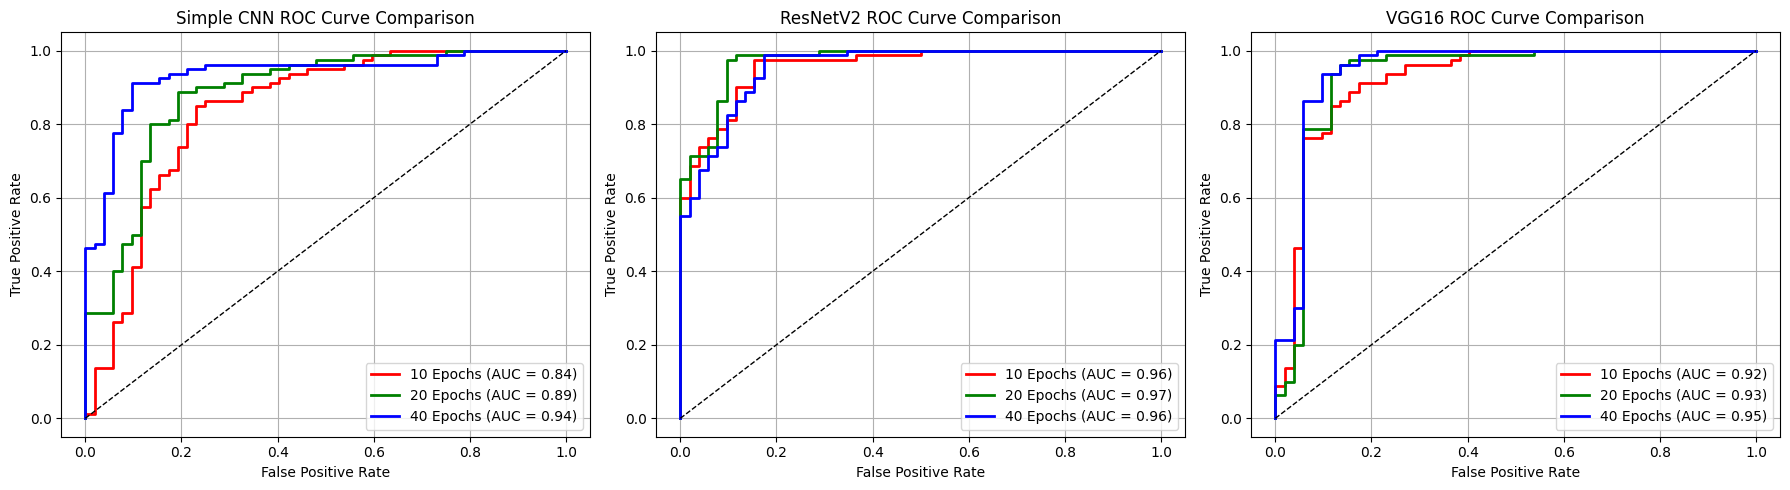

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


simple_preds = [validation_predictions1, validation_predictions2, validation_predictions3]
resnet_preds = [validation_predictions4, validation_predictions5, validation_predictions6]
vgg_preds = [validation_predictions7, validation_predictions8, validation_predictions9]


model_groups = [
    ("Simple CNN", simple_preds),
    ("ResNetV2", resnet_preds),
    ("VGG16", vgg_preds)
]


epoch_labels = ["10 Epochs", "20 Epochs", "40 Epochs"]
colors = ["red", "green", "blue"]


true_labels = validation_generator.labels


plt.figure(figsize=(18, 5))

for i, (model_name, preds_group) in enumerate(model_groups):
    plt.subplot(1, 3, i + 1)

    for pred, color, label in zip(preds_group, colors, epoch_labels):
        if pred.shape[1] == 2:
            fpr, tpr, _ = roc_curve(true_labels, pred[:, 1])
        else:
            fpr, tpr, _ = roc_curve(true_labels, pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f'{model_name} ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

plt.tight_layout()
plt.show()
